- https://wikidocs.net/44249

## 모듈

In [60]:
import re
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 데이터 로딩

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x1bf941ce700>)

In [3]:
train=pd.read_table('ratings_train.txt')
test=pd.read_table('ratings_test.txt')

In [4]:
train.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [43]:
test.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
print(f'train 갯수 : {train.shape}, test 갯수 : {test.shape}')

train 갯수 : (150000, 3), test 갯수 : (50000, 3)


### 훈련
---

In [7]:
train['document'].unique(), train['label'].unique()

(array(['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
        '너무재밓었다그래서보는것을추천한다', ..., '이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?',
        '청춘 영화의 최고봉.방황과 우울했던 날들의 자화상', '한국 영화 최초로 수간하는 내용이 담긴 영화'],
       dtype=object),
 array([0, 1], dtype=int64))

In [8]:
# document 열과 label 열의 중복을 제외한 값의 개수
train['document'].nunique(), train['label'].nunique()

(146182, 2)

In [9]:
# document 열의 중복 제거
train.drop_duplicates(subset=['document'], inplace=True)

In [10]:
len(train)

146183

In [30]:
train['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [33]:
train.groupby('label').count()

,id,document
label,,
0,73342,73342
1,72841,72840


<AxesSubplot:>

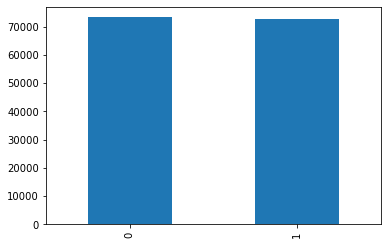

In [32]:
# 1: 긍정, 2: 부정
train['label'].value_counts().plot(kind = 'bar')

In [37]:
train.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [38]:
train.loc[train['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [42]:
train = train.dropna(how='any')
print(train.isnull().values.any())
print(len(train))

False
146182


### 테스트
---

In [44]:
test['document'].unique(), test['label'].unique()

(array(['굳 ㅋ', 'GDNTOPCLASSINTHECLUB',
        '뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아', ...,
        '그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다',
        '절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네', '마무리는 또 왜이래'],
       dtype=object),
 array([1, 0], dtype=int64))

In [46]:
# document 열과 label 열의 중복을 제외한 값의 개수
test['document'].nunique(), test['label'].nunique()

(49157, 2)

In [47]:
# document 열의 중복 제거
test.drop_duplicates(subset=['document'], inplace=True)

In [48]:
print(len(test))

49158


In [49]:
test['label'].value_counts()

1    24712
0    24446
Name: label, dtype: int64

In [50]:
test.groupby('label').count()

,id,document
label,,
0,24446,24446
1,24712,24711


<AxesSubplot:>

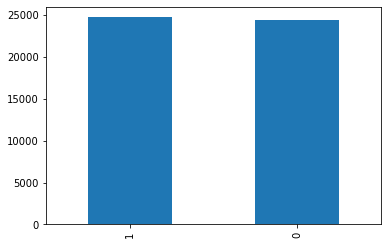

In [51]:
# 1: 긍정, 2: 부정
test['label'].value_counts().plot(kind = 'bar')

In [52]:
test.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [53]:
test.loc[test['document'].isnull()]

,id,document,label
5746,402110,NaN,1


In [54]:
test = test.dropna(how='any')
print(test.isnull().values.any())
print(len(test))

False
49157


### 한글 정규 표현식
- https://codingspooning.tistory.com/138

In [61]:
# 한글과 공백을 제외하고 모두 제거
train['document'] = train['document'].str.replace('[^ ㄱ-ㅣ가-힣+]', '')
train.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [64]:
test['document'] = test['document'].str.replace('[^ ㅣ가-힣+]', '')
test.head()

,id,document,label
0,6270596,굳,1
1,9274899,,0
2,8544678,뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임 돈주고 보기에는,0
4,6723715,만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠,0


In [67]:
# 기존에 한글이 없는 리뷰의 빈 값을 Null 값으로 변경
# white space 데이터를 empty value로 변경
train['document'] = train['document'].str.replace('^ +', "")
test['document'] = test['document'].str.replace('^ +', "")

train['document'].replace('', np.nan, inplace=True)
test['document'].replace('', np.nan, inplace=True)

print(train.isnull().sum())
print(test.isnull().sum())

id            0
document    785
label         0
dtype: int64
id            0
document    373
label         0
dtype: int64


In [68]:
train.loc[train.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [69]:
test.loc[test.document.isnull()][:5]

,id,document,label
1,9274899,NaN,0
116,6910486,NaN,1
254,4976468,NaN,0
468,7517102,NaN,0
504,2096424,NaN,0


In [70]:
train = train.dropna(how = 'any')
test = test.dropna(how = 'any')
print(len(train))
print(len(test))

145397
48784


In [31]:
# tlabel=train['label'].value_counts()
# tlabel[0], tlabel[1]
# plt.bar(1, tlabel[0])
# plt.bar(2, tlabel[1])
# plt.show()